In [49]:
from mynn import *
prefix = "random-direct"
θ, κ = preprocess_data()
θ_train, κ_train = θ[0::2], κ[:, :,  0::2]
θ_test, κ_test = θ[1::2], κ[:, :,  1::2]

coeff_scale = 100.0
# θ_test, κ_test = θ[0::2], κ[:, :,  0::2]



data_svd, bases, N_trunc = build_bases(κ_train, acc=0.999)


x_train = torch.from_numpy(θ_train.astype(np.float32))
y_train = torch.from_numpy(data_svd.astype(np.float32)*coeff_scale)

N_trunc =  62


In [55]:
N_θ = 8
model = DirectKernelRomNet(N_θ, N_trunc)

model = torch.load("DirectKernelRomNet.model")

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)


n_epochs = 500000
for epoch in range(n_epochs):
    
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_train)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_train)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
        
    if epoch % 10000 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "DirectKernelRomNet.model")

	
# save the model
torch.save(model, "DirectKernelRomNet.model")

[0/500000], loss: 52569.52
[10000/500000], loss: 52898.59
[20000/500000], loss: 52419.492
[30000/500000], loss: 52250.27
[40000/500000], loss: 52018.719
[50000/500000], loss: 51944.375
[60000/500000], loss: 52597.82
[70000/500000], loss: 51811.367
[80000/500000], loss: 52178.539
[90000/500000], loss: 53417.781
[100000/500000], loss: 52108.398
[110000/500000], loss: 53296.812
[120000/500000], loss: 54160.305
[130000/500000], loss: 51641.258
[140000/500000], loss: 52184.734
[150000/500000], loss: 51799.055
[160000/500000], loss: 52450.027
[170000/500000], loss: 51627.848
[180000/500000], loss: 51419.156
[190000/500000], loss: 51616.977
[200000/500000], loss: 51422.785
[210000/500000], loss: 51460.672
[220000/500000], loss: 51322.301
[230000/500000], loss: 52559.223
[240000/500000], loss: 51446.418
[250000/500000], loss: 51012.352
[260000/500000], loss: 51083.023
[270000/500000], loss: 51114.289
[280000/500000], loss: 50875.953
[290000/500000], loss: 50813.324
[300000/500000], loss: 50767

In [53]:
######################################################
N_θ = 8
N_data  =  θ_test.shape
N_x, N_y, N_data = κ_test.shape

L = 1.0
xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

model = torch.load("DirectKernelRomNet.model")
κ_pred = model(torch.from_numpy(θ_test.astype(np.float32))).detach().numpy()
κs_pred = np.zeros((N_x, N_y, N_data))
for i in range(N_data):
    κs_pred[:,:,i] = np.dot(κ_pred[i, :]/coeff_scale  , bases).reshape(N_x, N_y)

test_ids = np.arange(0, N_data)
errors = np.zeros(len(test_ids))



Average error is  13.91375798428219


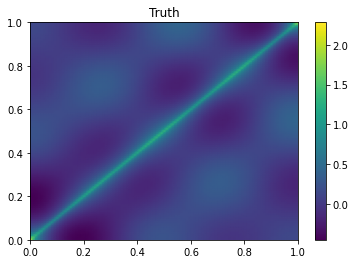

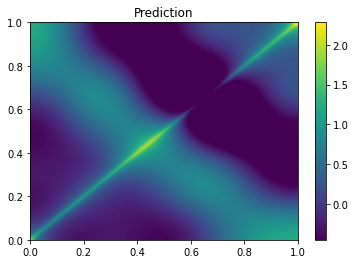

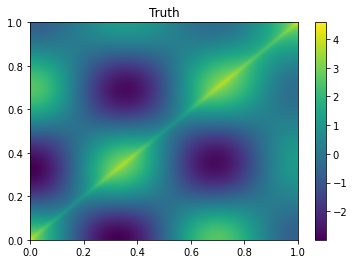

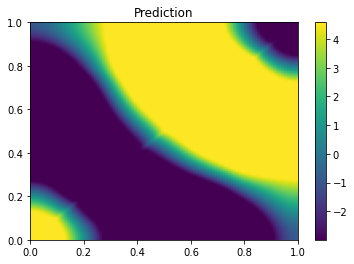

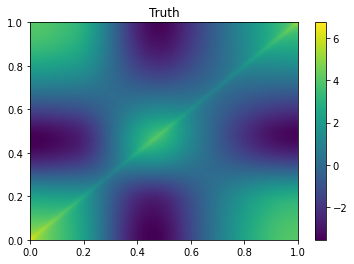

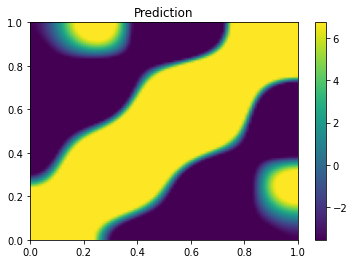

In [54]:
for test_id in test_ids:

    errors[test_id] =  np.linalg.norm(κs_pred[:, :, test_id] - κ_test[:, :, test_id])/np.linalg.norm(κ_test[:, :, test_id])
    # print(prefix+"data %i, relative error is %.5f:" % (test_id, errors[test_id]))

    if test_id %249 == 0:
        vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_test[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig(prefix+"Truth_%04i.png" % test_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κs_pred[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig(prefix+"Prediction_%04i.png" % test_id)

print("Average error is ", np.average(errors))




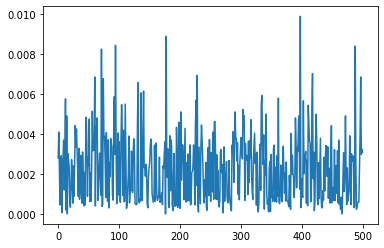

In [38]:
κs = κ_test

# Test projection error
N_trunc, _ = bases.shape
Nx, Ny, N_data = κs.shape
errors = np.zeros(N_data)
base_norms = np.linalg.norm(bases, axis=1)
for i in range(N_data):
    κ = κs[:, :, i].reshape(-1)
    rom_coeffs = np.dot(bases, κ)/base_norms**2
    errors[i] = np.linalg.norm(κ - np.dot(rom_coeffs,bases))/np.linalg.norm(κ)
fig = plt.figure()
plt.plot(errors)


In [40]:
i = 1
κ = κs[:, :, i].reshape(-1)
rom_coeffs = np.dot(bases, κ)/base_norms**2

In [41]:
rom_coeffs

array([-9.73153490e-03,  5.22996435e-03, -9.05976821e-03, -9.15782723e-03,
       -2.83080251e-02,  1.55031596e-03,  5.00587734e-02, -6.19999394e-02,
       -2.38382406e-02, -5.88618716e-02, -2.13115313e-02, -1.50972450e-02,
       -1.16593023e-02,  5.24690722e-04,  5.69684776e-03,  4.06602833e-03,
       -1.83167844e-04, -2.08921896e-03,  3.41125654e-03, -2.60413537e-03,
        3.44498876e-04,  4.65950756e-03,  2.29064276e-03,  2.14208008e-04,
       -3.32057910e-03,  1.21062669e-03,  4.23870637e-04, -3.08091105e-04,
        6.51968819e-04, -7.17279101e-04,  9.82044826e-04,  4.20686628e-04,
        6.65143143e-04, -3.80996909e-04, -5.20533434e-04, -1.61594483e-04,
        8.10947119e-05,  3.88852762e-04,  3.33378552e-04,  5.13007315e-06,
       -5.99594551e-06, -2.84014489e-06,  1.67453383e-05,  6.93071076e-05,
       -2.90674095e-04, -3.99635897e-04,  1.77464910e-05, -1.57951989e-04,
        1.73382589e-04,  2.23582910e-04, -2.50482792e-04, -3.05103893e-05,
       -1.63831035e-05,  